# Testing Notebook

### Imports

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy import interpolate
import time
from data_files import file_dict, runs_dict
from testing_class import testing
from range_estimator import range_est

### File Summary

In [2]:

batt_cap = 58   # kWh; useable energy

file_summary = pd.DataFrame({
    'Run_ID': [],
    'Time (min)': [],
    'Max Speed (kts)': [],
    'Avg Speed (kts)': [],
    'Energy Expended (kWh)': [],
    'Distance Traveled (nm)': [],
    'Average Consumption (kWh/nm)': []
})

for run in runs_dict.keys():
    runs_dict[run]['Pack Voltage 1 V'] = runs_dict[run]['Pack Voltage 1 V']*10
    
    time_elapsed = runs_dict[run]['Time'].iloc[-1] - runs_dict[run]['Time'].iloc[0]
    speed_max = runs_dict[run]['Speed m/s'].max()*1.944
    speed_avg = runs_dict[run]['Speed m/s'].mean()*1.944
    battery_expended = runs_dict[run]['SOC 1 %'].iloc[0] - runs_dict[run]['SOC 1 %'].iloc[-1]
    energy_expended = battery_expended*batt_cap/100
    distance_traveled = (runs_dict[run]['Distance km'].iloc[-1] - runs_dict[run]['Distance km'].iloc[0])*0.539957
    avg_consumption = (energy_expended)/distance_traveled

    file_summary.loc[len(file_summary.index)] = [
        run, 
        round(time_elapsed.seconds/60, 1),
        round(speed_max, 1),
        round(speed_avg, 1),
        round(energy_expended, 2),
        round(distance_traveled, 2),
        round(avg_consumption, 1)
        ]

file_summary

,Run_ID,Time (min),Max Speed (kts),Avg Speed (kts),Energy Expended (kWh),Distance Traveled (nm),Average Consumption (kWh/nm)
0,Run 1,55.4,12.9,7.6,5.22,3.64,1.4
1,Run 2,35.2,53.5,13.1,9.28,3.96,2.3
2,Run 3,23.4,13.2,8.5,2.90,1.70,1.7
3,Run 4,48.3,14.4,9.8,9.28,4.06,2.3
4,Run 5,32.6,12.3,7.7,2.90,2.16,1.3
5,Run 6,46.9,13.5,5.8,5.22,2.29,2.3
6,Run 7,67.0,21.4,8.3,10.44,4.78,2.2
7,Run 8,44.2,12.9,8.2,7.54,3.27,2.3
8,Run 9,63.5,15.0,8.9,11.60,4.87,2.4
9,Run 10,28.6,13.5,9.5,5.22,2.32,2.2


### Testing

In [3]:
"""Import Data from file manager"""
df = testing().add_variables(runs_dict['Run 26'])

# """Alternately, direct import from csv file"""
# file_path, rows_to_read = 'data/L230414.CSV', range(300, 3300)
# df_raw = pd.read_csv(file_path, skiprows=range(1,rows_to_read[0]), nrows=len(rows_to_read))
# df = testing().add_variables(df_raw)

In [4]:
'''Create algorithm instance'''
range_estimator = range_est(58, 2.5, 0.3, 0,0,0)

range_list = []
"""Test Loop"""
for i in range(len(df)):
    dataStream = testing().parse_csv(df.iloc[i])

    # range_estimator.overall_dist_avg(dataStream)
    range_estimator.overall_time_avg(dataStream)
    # range_estimator.rolling_avg(dataStream)
    
    # print('Battery Remaining = %.1f percent | Range Remaining = %.1f nm' 
    #       % (dataStream['soc'], range_estimator.range_remaining), end=' \r')
    # time.sleep(.005)
    range_list.append(range_estimator.range_remaining)


### Accuracy

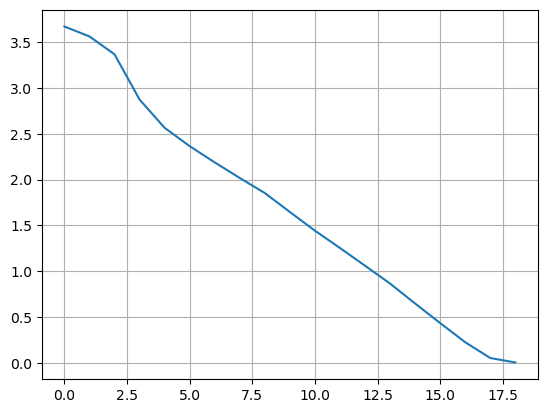

In [5]:
run_error, errors = testing().test_accuracy(df, range_list, interval=100)
plt.plot(range(len(errors)), errors)
plt.grid()

### Method Comparison Simulation

In [6]:
# Values to be stored in inifile
batt_cap = 58
stored_dist_avg = 2.5
stored_time_avg = 0.3
n_runs = 0
roll_energy = 0
roll_distance = 0

# Class instances
test_inst = testing()
range_est = range_est(batt_cap,
                      stored_dist_avg,
                      stored_time_avg,
                      n_runs,
                      roll_energy,
                      roll_distance)

# lists to store accuracy of each run by different methods
accuracies1 = []
accuracies2 = []
accuracies3 = []

# Loop through runs
for run in runs_dict.keys():
    df = test_inst.add_variables(runs_dict[run])

    # lists to store range values
    range_dist_list = []
    range_time_list = []
    range_roll_list = []

    # Loop through rows of current run data
    for i in range(len(df)):
        # Simulate dataStream
        data = test_inst.parse_csv(df.iloc[i])

        # Record range remaining for each method
        range_est.overall_dist_avg(data)
        range_dist_list.append(range_est.range_remaining)

        range_est.overall_time_avg(data)
        range_time_list.append(range_est.range_remaining)

        range_est.rolling_avg(data)
        range_roll_list.append(range_est.range_remaining)

    # Update averages once run is complete
    range_est.update_avg(data)

    # Check and record accuracy
    error_dist, errors_dist = test_inst.test_accuracy(df, range_dist_list)
    error_time, errors_time = test_inst.test_accuracy(df, range_time_list)
    error_roll, errors_roll = test_inst.test_accuracy(df, range_roll_list)

    accuracies1.append(error_dist)
    accuracies2.append(error_time)
    accuracies3.append(error_roll)

    print(run, 'Error', error_dist, error_time, error_roll, end=' \r')

# Create dataframe to store error values of each method for each run
error_summary = pd.DataFrame({
    'Run': runs_dict.keys(),
    'Overall Distance Average': accuracies1,
    'Overall Time Average': accuracies2,
    'Rolling Average': accuracies3
})


In [7]:
error_summary

,Run,Overall Distance Average,Overall Time Average,Rolling Average
0,Run 1,0.846792,1.903917,4.336428
1,Run 2,0.929311,1.481561,3.609020
2,Run 3,0.068244,0.627691,1.658873
3,Run 4,0.700122,1.933990,3.085688
4,Run 5,0.417237,1.013281,1.537236
5,Run 6,0.292461,1.405635,4.900685
6,Run 7,0.402360,2.287570,2.195976
7,Run 8,0.252075,1.150097,1.564735
8,Run 9,0.458362,2.244481,13.762312
9,Run 10,0.215383,0.910508,3.754358



 Distance Avg Error:     0.670268047670559 
 Time Avg Error:         1.7916951977440714 
 Rolling Avg Error:      4.209876908985242


Text(0, 0.5, 'Error (nm)')

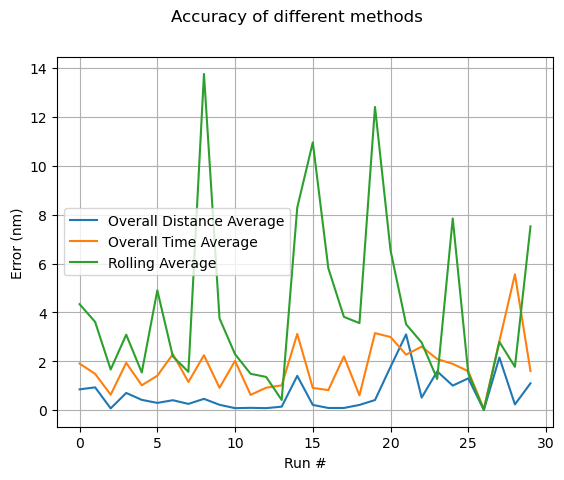

In [8]:
print('\n', 
      'Distance Avg Error:    ', error_summary['Overall Distance Average'].mean(), '\n', 
      'Time Avg Error:        ', error_summary['Overall Time Average'].mean(), '\n',
      'Rolling Avg Error:     ', error_summary['Rolling Average'].mean())

plt.plot(error_summary.index, 
         error_summary['Overall Distance Average'],
         error_summary.index,  
         error_summary['Overall Time Average'],
         error_summary.index, 
         error_summary['Rolling Average']
         )
plt.grid()
plt.legend(error_summary.columns[1:])
plt.suptitle('Accuracy of different methods')
plt.xlabel('Run #')
plt.ylabel('Error (nm)')

## Extra

In [9]:
# '''Summary Plots'''
# plt.figure(figsize=(12,5))

# plt.subplot(2,2,1)
# plt.plot(df.index, df['SOC 1 %'])
# plt.grid()
# plt.title('Charge (%) over Time')

# plt.subplot(2,2,2)
# plt.plot(df.index, df['Speed m/s']) #, df['Power 1 kW'])
# plt.grid()
# plt.title('Power (kW) and Speed (kts) over Time')

# plt.subplot(2,2,3)
# plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
# plt.grid()
# plt.title('Current and Voltage over Time')

# # plt.subplot(2,2,4)
# # plt.plot(df.index)
# # plt.grid()
# # plt.title('Empty')

# plt.subplots_adjust(hspace = 0.5)
# plt.subplots_adjust(wspace = 0.3)

# df.head()